In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline

## LOAD DATA

In [3]:
df = pd.read_csv(r"C:\Users\aruna\Downloads\archive\postings.csv")
df.head()

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,...,Requirements: \n\nWe are seeking a College or ...,1.713398e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,38480.0,8540.0,34021.0
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,1.0,NaN,...,NaN,1.712858e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,83200.0,80521.0,8069.0
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,...,We are currently accepting resumes for FOH - A...,1.713278e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,55000.0,45202.0,39061.0
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,16.0,NaN,...,This position requires a baseline understandin...,1.712896e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,157500.0,11040.0,36059.0
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,80000.0,YEARLY,"Burlington, IA",NaN,3.0,NaN,...,NaN,1.713452e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,70000.0,52601.0,19057.0


In [4]:
def show_null_count(df, col):
    # Check if the column exists in the DataFrame
    if col in df.columns:
        # Calculate the number of null values in the column
        null_count = df[col].isnull().sum()
        print(f"Total null values in '{col}': {null_count}")
    else:
        print(f"Column '{col}' does not exist in the DataFrame.")


In [6]:
for column in df.columns:
    show_null_count(df, column)

Total null values in 'job_id': 0
Total null values in 'company_name': 1719
Total null values in 'title': 0
Total null values in 'description': 7
Total null values in 'max_salary': 94056
Total null values in 'pay_period': 87776
Total null values in 'location': 0
Total null values in 'company_id': 1717
Total null values in 'views': 1689
Total null values in 'med_salary': 117569
Total null values in 'min_salary': 94056
Total null values in 'formatted_work_type': 0
Total null values in 'applies': 100529
Total null values in 'original_listed_time': 0
Total null values in 'remote_allowed': 108603
Total null values in 'job_posting_url': 0
Total null values in 'application_url': 36665
Total null values in 'application_type': 0
Total null values in 'expiry': 0
Total null values in 'closed_time': 122776
Total null values in 'formatted_experience_level': 29409
Total null values in 'skills_desc': 121410
Total null values in 'listed_time': 0
Total null values in 'posting_domain': 39968
Total null v

In [7]:
def drop_column(df, col):
    # Drop the specified column if it exists, ignoring errors if it doesn't
    df = df.drop(columns=[col], errors='ignore')
    if col in df.columns:
        print(f"Column '{col}' has been dropped.")
    else:
        print(f"Column '{col}' does not exist in the DataFrame.")
    return df

In [8]:
df = drop_column(df, 'job_posting_url')
df = drop_column(df, 'application_url')
df = drop_column(df, 'application_type')
df = drop_column(df, 'formatted_experience_level')
df = drop_column(df, 'posting_domain')
df = drop_column(df, 'zip_code')

Column 'job_posting_url' does not exist in the DataFrame.
Column 'application_url' does not exist in the DataFrame.
Column 'application_type' does not exist in the DataFrame.
Column 'formatted_experience_level' does not exist in the DataFrame.
Column 'posting_domain' does not exist in the DataFrame.
Column 'zip_code' does not exist in the DataFrame.


In [9]:
df.columns

Index(['job_id', 'company_name', 'title', 'description', 'max_salary',
       'pay_period', 'location', 'company_id', 'views', 'med_salary',
       'min_salary', 'formatted_work_type', 'applies', 'original_listed_time',
       'remote_allowed', 'expiry', 'closed_time', 'skills_desc', 'listed_time',
       'sponsored', 'work_type', 'currency', 'compensation_type',
       'normalized_salary', 'fips'],
      dtype='object')

In [10]:
def convert_unix_to_ddmmyyyy(df, col):
    # Check if the column exists in the DataFrame
    if col in df.columns:
        # Attempt to convert the column to numeric, coercing errors
        df[col] = pd.to_numeric(df[col], errors='coerce')

        # Convert from milliseconds to seconds for Unix timestamps
        df[col] = pd.to_datetime(df[col] / 1000.0, unit='s', errors='coerce')

        # Format dates as 'dd-mm-yyyy', leaving NaT (Not a Time) values unchanged
        df[col] = df[col].dt.strftime('%d-%m-%Y')

        print(f"Column '{col}' has been converted to 'dd-mm-yyyy' format.")
    else:
        print(f"Column '{col}' does not exist in the DataFrame.")

    return df  # Return the modified DataFrame

In [11]:
df = convert_unix_to_ddmmyyyy(df, 'original_listed_time')
df = convert_unix_to_ddmmyyyy(df, 'listed_time')
df['original_listed_time'].head()
df['listed_time'].head()

Column 'original_listed_time' has been converted to 'dd-mm-yyyy' format.
Column 'listed_time' has been converted to 'dd-mm-yyyy' format.


0    17-04-2024
1    11-04-2024
2    16-04-2024
3    12-04-2024
4    18-04-2024
Name: listed_time, dtype: object

In [12]:
def fill_with_median(df, col):
    # Fill missing values in the specified column with the median
    df[col].fillna(df[col].median(), inplace=True)
    return df

In [13]:
df = fill_with_median(df, 'max_salary')


C:\Users\aruna\AppData\Local\Temp\ipykernel_12292\434082048.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


In [14]:
def fill_with_mean(df, col):
    # Fill missing values in the specified column with the mean
    df[col].fillna(df[col].mean(), inplace=True)
    return df

In [15]:
def fill_nulls_with_normalized_values_min_max(df, col):
    if col in df.columns:
        # Initialize the MinMaxScaler
        scaler = MinMaxScaler()

        # Normalize the column values, ignoring nulls
        # First, we need to handle nulls: we will fill them temporarily with the column mean
        temp_col = df[col].fillna(df[col].mean())

        # Reshape the data to fit the scaler (2D array expected)
        normalized_values = scaler.fit_transform(temp_col.values.reshape(-1, 1))

        # Replace the original column values with the normalized values
        # Fill nulls in the original column with the corresponding normalized values
        df[col] = df[col].fillna(pd.Series(normalized_values.flatten(), index=df.index))

        print(f"Null values in column '{col}' have been replaced with normalized values.")
    else:
        print(f"Column '{col}' does not exist in the DataFrame.")

    return df  # Return the modified DataFrame


In [16]:
df = fill_nulls_with_normalized_values_min_max(df, 'normalized_salary')

Null values in column 'normalized_salary' have been replaced with normalized values.


In [17]:
df['normalized_salary'].isnull().sum()

0

In [18]:
def calculate_time_difference(df, listed_time_col, expiry_col, new_col='time_difference'):
    if listed_time_col in df.columns and expiry_col in df.columns:
        # Ensure the specified columns are in datetime format
        df[listed_time_col] = pd.to_datetime(df[listed_time_col], errors='coerce')
        df[expiry_col] = pd.to_datetime(df[expiry_col], errors='coerce')

        # Calculate the difference and store it in the new column
        df[new_col] = df[expiry_col] - df[listed_time_col]

        print(f"Time difference calculated and stored in column '{new_col}'.")
    else:
        print(f"One or both columns '{listed_time_col}' and '{expiry_col}' do not exist in the DataFrame.")

    return df  # Return the modified DataFrame

In [19]:
df = calculate_time_difference(df, 'listed_time', 'expiry')


Time difference calculated and stored in column 'time_difference'.


C:\Users\aruna\AppData\Local\Temp\ipykernel_12292\912657346.py:4: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[listed_time_col] = pd.to_datetime(df[listed_time_col], errors='coerce')


In [20]:
def fill_nan_values_with_0(df, col):
    if col in df.columns:
        df[col].fillna(0, inplace=True)
        print(f"Null values in column '{col}' have been replaced with 0.")
        return df
    else:
        print(f"Column '{col}' does not exist in the DataFrame.")
        return df


In [21]:
df = fill_nan_values_with_0(df, 'remote_allowed')

Null values in column 'remote_allowed' have been replaced with 0.


C:\Users\aruna\AppData\Local\Temp\ipykernel_12292\1218723988.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(0, inplace=True)


In [26]:
df['remote_allowed'].isnull().sum()

0

In [30]:
def if_one_col_present_replace_with_other_else_generic(df, col1, col2):
    # Remove records where both col1 and col2 are null
    df = df.dropna(subset=[col1, col2], how='all')

    # Replace null values in col1 with values from col2
    df[col1] = df[col1].fillna(df[col2])

    # Replace null values in col2 with values from col1
    df[col2] = df[col2].fillna(df[col1])

    return df  # Return the modified DataFrame


In [31]:
df = if_one_col_present_replace_with_other_else_generic(df, 'company_name', 'company_id')

C:\Users\aruna\AppData\Local\Temp\ipykernel_12292\3945946901.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col1] = df[col1].fillna(df[col2])
C:\Users\aruna\AppData\Local\Temp\ipykernel_12292\3945946901.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col2] = df[col2].fillna(df[col1])


In [32]:
df['company_id'].isnull().sum()

0

In [33]:
import numpy as np
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_time_series(df, time_col):
    # Convert the time column to datetime if not already
    df[time_col] = pd.to_datetime(df[time_col], errors='coerce')

    # Create a new column for month-year format
    df['month_year'] = df[time_col].dt.to_period('M')

    # Count occurrences per month
    monthly_counts = df['month_year'].value_counts().sort_index()

    # Plotting
    plt.figure(figsize=(12, 6))
    monthly_counts.plot(
        title=f'Count Over Time for {time_col}',
        color='blue',
        linewidth=2
    )
    plt.xlabel('Month-Year')
    plt.ylabel('Count')
    plt.grid()
    plt.xticks(rotation=45)
    plt.show()

def plot_bar(df, column):
    plt.figure(figsize=(12, 6))
    df[column].value_counts().plot(
        kind='bar',
        title=f'Distribution of {column}',
        color='skyblue',
        edgecolor='black'
    )
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()

def plot_box(df, column):
    plt.figure(figsize=(12, 6))
    plt.boxplot(df[column].dropna(), vert=False)  # Drop null values for the plot
    plt.title(f'Box Plot of {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.grid(True)
    plt.show()

def plot_histogram(df, column):
    plt.figure(figsize=(12, 6))
    df[column].hist(bins=30, color='lightgreen', edgecolor='black')
    plt.title(f'Histogram of {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(axis='y')
    plt.show()

def plot_scatter(df, x_col, y_col):
    plt.figure(figsize=(12, 6))
    plt.scatter(df[x_col], df[y_col], alpha=0.6, color='orange')
    plt.title(f'Scatter Plot: {x_col} vs {y_col}', fontsize=14)
    plt.xlabel(x_col, fontsize=12)
    plt.ylabel(y_col, fontsize=12)
    plt.grid()
    plt.show()

def plot_heatmap(df, columns):
    plt.figure(figsize=(12, 8))
    sns.heatmap(df[columns].corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
    plt.title('Correlation Heatmap', fontsize=16)
    plt.show()

def plot_pairplot(df, columns):
    sns.pairplot(df[columns], diag_kind='kde', plot_kws={'alpha': 0.5})
    plt.suptitle('Pair Plot', y=1.02, fontsize=16)
    plt.show()

# Decompose time series data to identify trends and seasonality.
def plot_decomposition(df, time_col):
    plt.figure(figsize=(12, 8))
    decomposition = seasonal_decompose(df[time_col], model='additive')
    decomposition.plot()
    plt.suptitle('Time Series Decomposition', fontsize=16)
    plt.show()

def plot_pca(df):
    # Select the columns for PCA
    columns = ['max_salary', 'min_salary', 'med_salary', 'views', 'applies']

    # Check if we have enough non-null data points
    if df[columns].dropna().shape[0] < 2:
        print("Not enough data for PCA after dropping NaNs.")
        return

    # Impute missing values with the mean of each column
    imputer = SimpleImputer(strategy='mean')
    imputed_df = imputer.fit_transform(df[columns])

    # Perform PCA
    pca = PCA(n_components=2)
    components = pca.fit_transform(imputed_df)

    # Plot the PCA results
    plt.figure(figsize=(10, 8))
    plt.scatter(components[:, 0], components[:, 1], alpha=0.5, c='blue')
    plt.title('PCA of Job Postings')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid()
    plt.show()

def plot_distribution(df, column):
    plt.figure(figsize=(12, 6))
    sns.histplot(df[column], kde=True, bins=30)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid()
    plt.show()

#Compare the cumulative distribution of salaries to understand
# the percentage of jobs falling below a certain salary threshold
def plot_cdf(df, column):
    plt.figure(figsize=(12, 6))
    sorted_data = np.sort(df[column].dropna())
    y = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    plt.plot(sorted_data, y, marker='.', linestyle='none')
    plt.title(f'Cumulative Distribution Function of {column}')
    plt.xlabel(column)
    plt.ylabel('Cumulative Probability')
    plt.grid()
    plt.show()

def plot_stacked_bar(df, column1, column2):
    cross_tab = pd.crosstab(df[column1], df[column2])
    cross_tab.plot(kind='bar', stacked=True, figsize=(12, 6))
    plt.title(f'Stacked Bar Plot of {column1} by {column2}')
    plt.xlabel(column1)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()


## Key Observations
# Salary Columns (max_salary, min_salary, med_salary):

These columns are highly correlated with each other:
max_salary and min_salary have a perfect correlation of 1.00, indicating that these values are linearly dependent.
med_salary is also strongly correlated with min_salary and max_salary.

# Views and Applications (views, applies):
views and applies have a moderately strong positive correlation (0.49). This means that as the number of job views increases, the number of applications also tends to increase.
This is logical since more exposure (views) often leads to more interest (applications).

# Salary vs. Engagement Metrics:
The salary columns (max_salary, min_salary, med_salary) show very weak or negligible correlations with views and applies (values close to 0).
This implies that salary ranges in job postings might not significantly influence how often the jobs are viewed or applied for.

# Applications vs. Salary:
The correlation between applies and the salary columns is very weak (values close to 0 or slightly negative), suggesting that other factors (e.g., job description, company reputation, location) might influence applications more than salary.

## Conclusion
This heatmap highlights relationships in the data that can guide further analysis:

The strong correlations among salary columns suggest redundancy in storing all three (max_salary, min_salary, and med_salary). 
The moderate correlation between views and applies underscores the importance of job visibility for attracting applications.
The weak correlation between salary and engagement metrics suggests that salaries alone are not major drivers of job posting popularity.

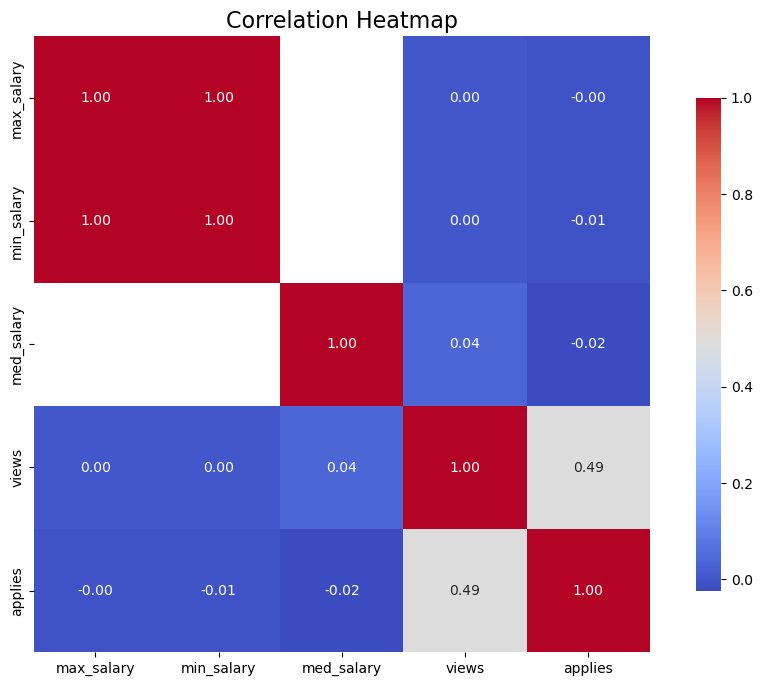

In [53]:
plot_heatmap(df, ['max_salary', 'min_salary', 'med_salary', 'views', 'applies'])

## Key Observations

# Dominance of Full-Time Jobs:

The majority of job postings are for FULL_TIME work. This is evident from the significantly taller bar for FULL_TIME compared to other work types.
Most full-time jobs (blue section) do not allow remote work, but a small proportion (orange section) does.

# Remote Work in Other Job Types:
CONTRACT: Some remote work is allowed for contract positions (orange segment), but most contract jobs do not offer remote options.
PART_TIME: There is a smaller but noticeable number of remote positions for part-time jobs.
INTERNSHIP, TEMPORARY, VOLUNTEER, and OTHER:
These work types have significantly fewer job postings overall.
The orange segments for these categories are minimal or non-existent, indicating that remote work options are rare for these types of jobs.

# Remote vs. On-site Work Trends:
Across all work types, the blue segments dominate the orange ones, suggesting that the majority of jobs in this dataset do not allow remote work.
Implications of the Visualization
The graph emphasizes the popularity of full-time positions in the job market, with fewer opportunities for part-time, temporary, or volunteer work.
Remote work is available but not the norm, with most jobs requiring on-site presence regardless of the work type.
Remote work is more common in FULL_TIME, CONTRACT, and PART_TIME roles compared to other job types.

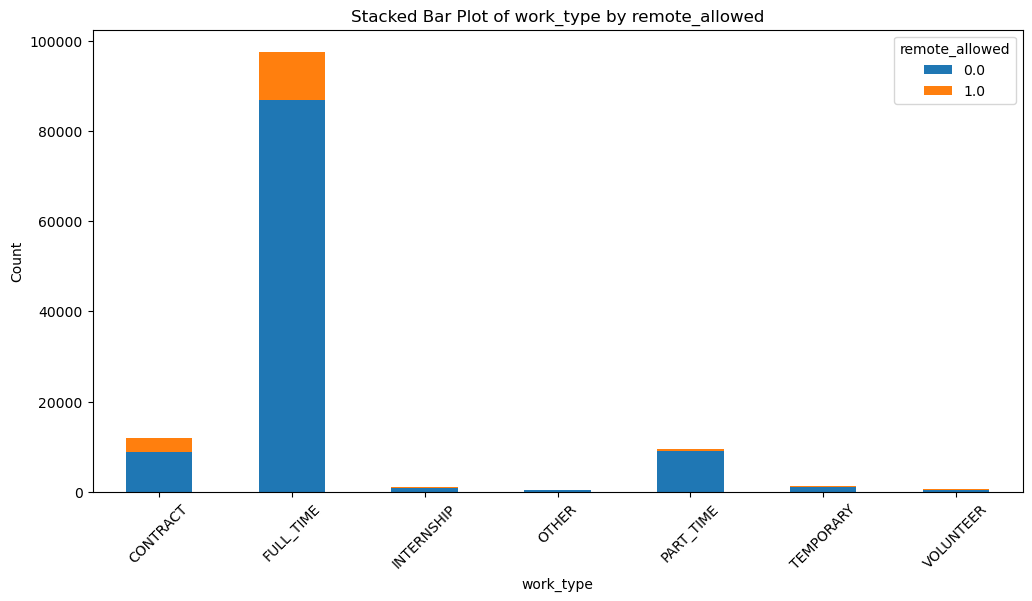

In [63]:
plot_stacked_bar(df, 'work_type', 'remote_allowed')


## Key Observations
# 1. Understanding Popularity of Jobs
Peak of the Distribution: The highest point in the histogram (or KDE curve) represents the most common application_rate across all job postings.
If the peak is near 0, it indicates that most job postings attract relatively few applications compared to the number of views.
A higher peak near a larger value suggests that many job postings receive proportionally more applications, indicating higher engagement.
# 2. Identifying Outliers
Right-Tail Observations: Jobs with exceptionally high application_rate are visible in the far-right tail. These are roles with a high number of applications relative to views, likely indicating highly desirable positions (e.g., competitive pay, prestigious companies, or high-demand skills).
Left-Tail Observations: Jobs with very low or zero application_rate might indicate postings that are not engaging viewers. This could reflect roles with:
Mismatched job descriptions.
Niche skill requirements.
Low attractiveness of job benefits.
# 3. Skewness and Distribution Shape
Right-Skewed Distribution: If the histogram is right-skewed, it suggests that the majority of jobs have low to moderate application_rate, with fewer jobs showing high engagement.
Normal or Uniform Distribution: A bell-shaped or even distribution indicates that application rates are more evenly spread, suggesting consistent interest across job postings.
# 4. Implications for Job Seekers
Targeting High-Engagement Jobs: Job seekers can analyze high application_rate categories to identify traits (e.g., job type, company size, industry) that make certain roles more appealing.
Low Engagement as Opportunity: Jobs with very low application_rate might reflect less competition, offering an opportunity for applicants with matching skills.
# 5. Implications for Recruiters
Improving Job Listings: Recruiters can analyze why certain postings perform poorly. This could involve:
Refining job descriptions.
Providing more details about compensation or benefits.
Targeting job ads to the right audience.
Market Demand Analysis: A cluster of postings with high application_rate suggests areas of high job market demand, helping employers focus their hiring strategies.
# 6. Trends Across Industries or Roles
Segmented Analysis: By filtering the dataset based on job categories, industries, or geographies, recruiters and analysts can compare application_rate distributions across segments to identify trends in job market demand and competition.

## Additional Observations:
the histogram shows most values between 0.1 and 0.3: It suggests that, on average, 10% to 30% of viewers apply to job postings.
there’s a long tail extending past 1.0: Certain jobs receive disproportionately high applications compared to views, likely reflecting competitive roles.

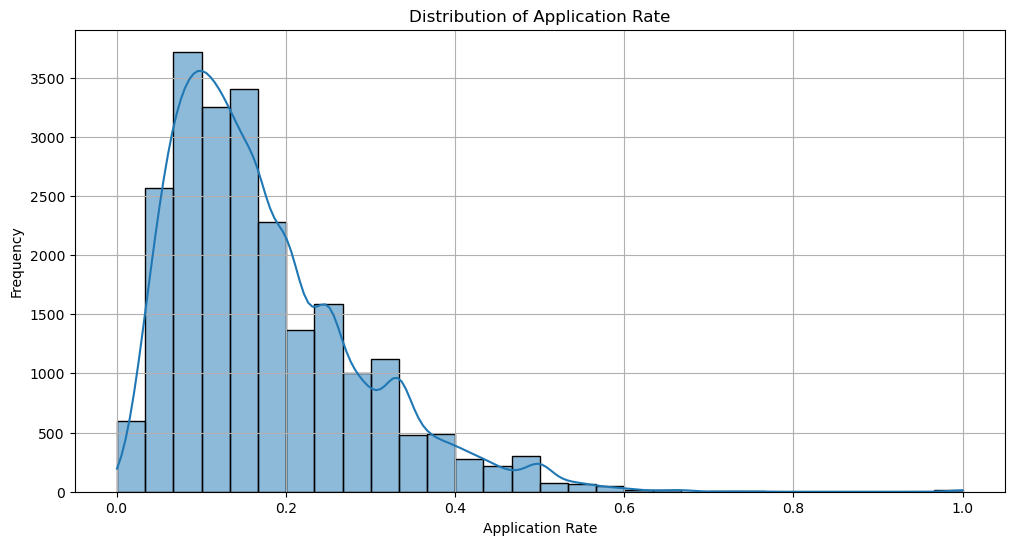

In [66]:
df['application_rate'] = df['applies'] / df['views']

def plot_application_rate(df):
    plt.figure(figsize=(12, 6))
    sns.histplot(df['application_rate'].dropna(), bins=30, kde=True)
    plt.title('Distribution of Application Rate')
    plt.xlabel('Application Rate')
    plt.ylabel('Frequency')
    plt.grid()
    plt.show()

# Example usage
plot_application_rate(df)

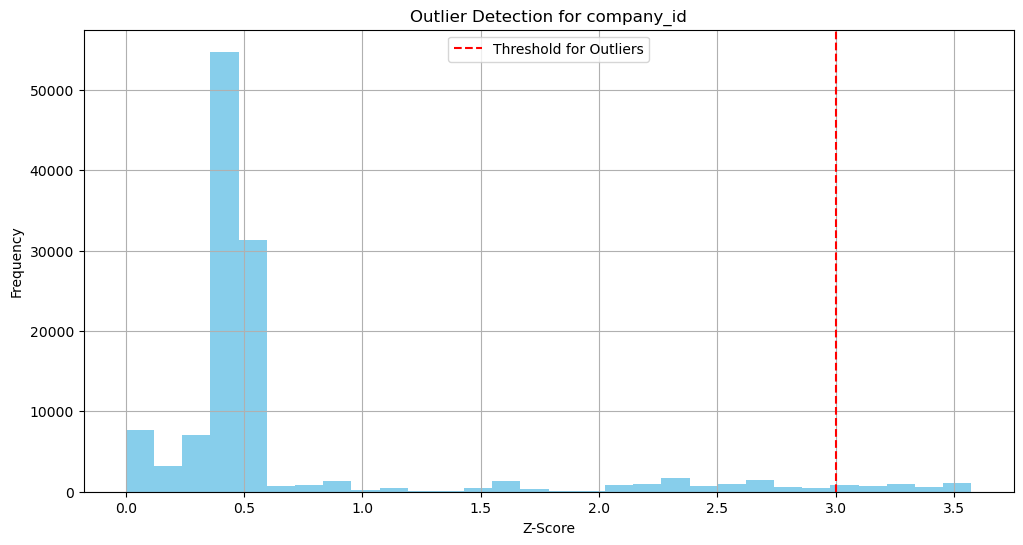

In [67]:
from scipy import stats

def plot_outliers(df, column):
    z_scores = np.abs(stats.zscore(df[column].dropna()))
    plt.figure(figsize=(12, 6))
    plt.hist(z_scores, bins=30, color='skyblue')
    plt.axvline(3, color='red', linestyle='--', label='Threshold for Outliers')
    plt.title(f'Outlier Detection for {column}')
    plt.xlabel('Z-Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid()
    plt.show()

# Example usage
plot_outliers(df, 'company_id')

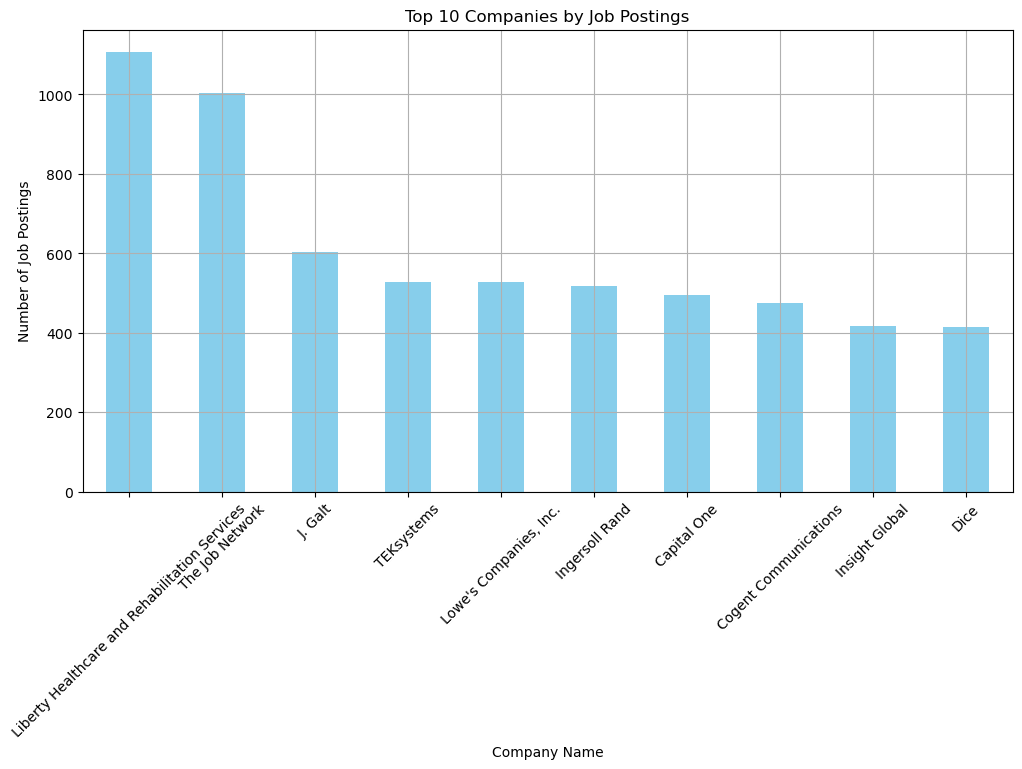

In [70]:
def plot_top_companies(df, column, title):
    top_companies = df[column].value_counts().nlargest(10)
    plt.figure(figsize=(12, 6))
    top_companies.plot(kind='bar', color='skyblue')
    plt.title(title)
    plt.xlabel('Company Name')
    plt.ylabel('Number of Job Postings')
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

plot_top_companies(df, 'company_name', 'Top 10 Companies by Job Postings')


## Key Observations

The graph presents the average maximum salaries by work type derived from the formatted_work_type column in the dataset. Here's a detailed breakdown of insights:

# Highest-Paying Work Type:

Full-time roles show the highest average maximum salary, indicating that these jobs offer more lucrative compensation compared to other work types.

# Internship vs. Full-Time:

Internship roles have the lowest average maximum salary, which aligns with the expectation that internships are usually meant for gaining experience rather than high pay.

# Part-Time and Temporary Roles:

Part-time and temporary work types fall in the mid-range, suggesting moderate pay. These may suit individuals seeking flexibility or short-term engagements.

# Contract Roles:

Contract jobs offer a salary closer to full-time but slightly lower, which might be due to the temporary nature of such roles despite requiring similar expertise.

# Volunteer Work:

Volunteer positions show a surprisingly high average max salary, which could indicate the inclusion of some niche, specialized, or funded volunteer positions in the dataset.

# Other Roles:

The "Other" category has a fairly high average salary, signifying its potential inclusion of non-standard roles that might be well-compensated.

# Other Insights:

Job Seekers: Can identify which work types align with their financial goals (e.g., prioritize full-time or contract roles for higher pay).

Employers: May use this data to benchmark salaries based on work types to attract the best talent.

Recruiters: Helps target candidates for specific roles by highlighting financial incentives in job postings.  

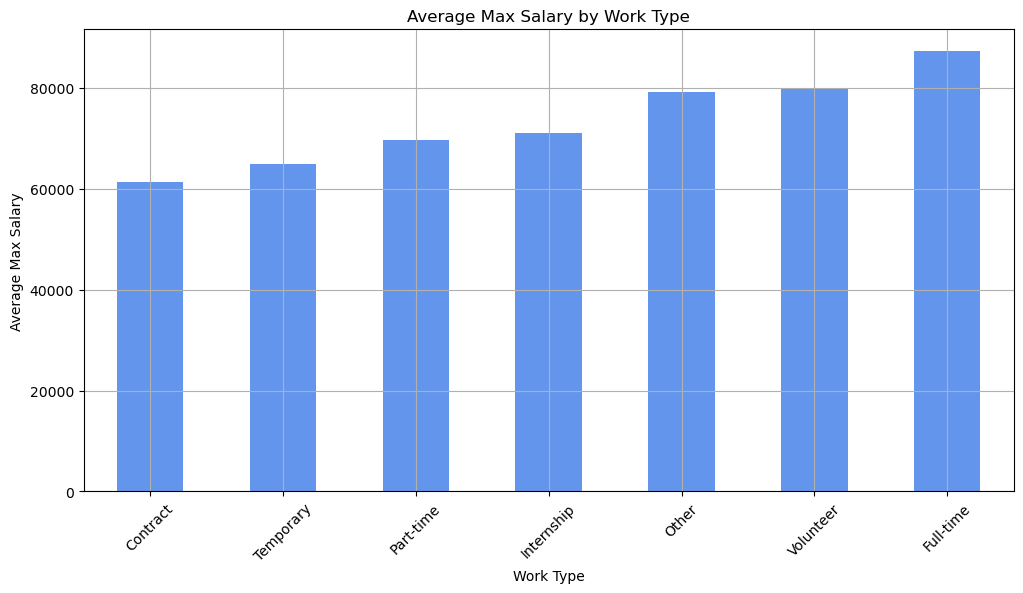

In [73]:
def plot_salary_by_work_type(df, title):
    plt.figure(figsize=(12, 6))
    df.groupby('formatted_work_type')['max_salary'].mean().sort_values().plot(kind='bar', color='cornflowerblue')
    plt.title(title)
    plt.xlabel('Work Type')
    plt.ylabel('Average Max Salary')
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

plot_salary_by_work_type(df, 'Average Max Salary by Work Type')


The graph represents the average views per job posting by work type from the dataset. 


# High Popularity of Contract Roles:

Contract roles receive the highest average views per job posting, suggesting a significant interest in short-term or project-based opportunities among job seekers. This could be due to flexibility or specialized skills being in demand for contract work.

# Internships Also Attract Attention:

Internship postings have the second-highest average views. This highlights strong interest among students or early-career professionals looking for experience and skill-building opportunities.

# Moderate Interest in Full-Time Roles:

Surprisingly, full-time roles receive fewer average views than internships and contract roles, possibly because full-time positions are abundant, making individual postings less attention-grabbing.

# Temporary Roles:

Temporary jobs have a moderate number of views, which might reflect a niche interest for those looking for short-term but non-contractual positions.

# Low Engagement with Part-Time and Volunteer Roles:

Part-time and volunteer roles receive the fewest views, indicating they may be less sought after. Volunteer roles, in particular, might appeal to a smaller audience with specific interests in community service or non-profit work.

# Other Work Types:

The "Other" category sees moderate engagement, suggesting that roles outside standard classifications still attract job seekers, albeit to a lesser degree.

# Potential Applications of Insights:

# Recruiters and Hiring Managers:

Recognize that contract and internship postings might need less aggressive promotion since they naturally attract high interest.
For part-time or volunteer roles, emphasize unique selling points to boost engagement.

# Job Seekers:

Understand competitive areas like contract jobs and internships to tailor applications and stand out in high-visibility postings.

# Platform Optimization:

LinkedIn or similar platforms can refine job posting algorithms, prioritizing under-viewed categories like volunteer or part-time jobs to balance engagement.

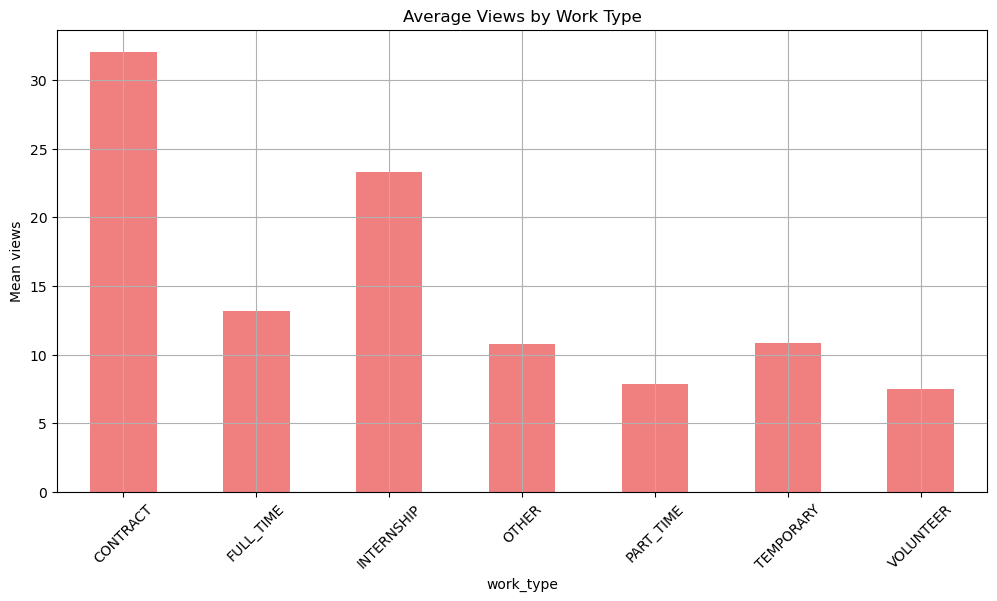

In [76]:
def plot_grouped_bar(df, category_col, value_col, title):
    plt.figure(figsize=(12, 6))
    df.groupby(category_col)[value_col].mean().plot(kind='bar', color='lightcoral')
    plt.title(title)
    plt.xlabel(category_col)
    plt.ylabel(f'Mean {value_col}')
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()


plot_grouped_bar(df, 'work_type', 'views', 'Average Views by Work Type')


The graph visualizes the top 10 companies by the number of applications received from the dataset.

# Insights from the Graph:

# Insight Global Dominates Applications:

Insight Global stands out as the company with the highest number of applications, receiving over 3,000. This indicates its strong employer brand, appealing job offerings, or wide reach among job seekers.

# Swooped Holds Second Place:

Swooped also receives significant attention, ranking just behind Insight Global. This highlights its popularity or the attractiveness of the roles it posts.

# Other Popular Companies:

Companies like Compunnel Inc., Robert Half, and Akkodis also receive high application counts, but with a noticeable drop compared to Insight Global and Swooped. These companies likely have strong reputations or roles appealing to large audiences.

# Significant Competition for Top 10:

The other companies in the top 10, such as Apex Systems, DataAnnotation, Motion Recruitment, Somnea Health, and Talent Groups, receive over 1,000 applications each, reflecting competitive interest in their job postings.

# Industry Relevance:

Many of these companies are staffing or recruitment firms (e.g., Robert Half, Insight Global), which post a variety of roles. Their high application numbers could indicate a broader reach across job categories.

# Demand for Recruitment Agencies:

Recruitment agencies (e.g., Insight Global, Robert Half) dominate the chart, likely because they offer multiple job opportunities and cater to diverse industries and job seekers.

# Specialized Opportunities:

Companies with unique roles (e.g., Swooped or DataAnnotation) may attract job seekers looking for niche or high-demand skill sets.

# Employer Branding:

The top companies likely have robust employer branding and marketing strategies that increase their visibility and appeal on platforms like LinkedIn.
Practical Applications of Insights:

# For Recruiters:

Companies outside the top 10 can analyze these leaders’ job postings to understand what drives high application numbers (e.g., job descriptions, benefits, branding).

# For Job Seekers:

Job seekers can identify competitive employers, assess high-demand job roles, and better prepare their applications for these companies.

# For LinkedIn:

LinkedIn could promote opportunities from less popular companies to balance application distributions or highlight niche roles from smaller employers.

C:\Users\aruna\AppData\Local\Temp\ipykernel_12292\739767618.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_companies, x='applies', y='company_name', palette='viridis')


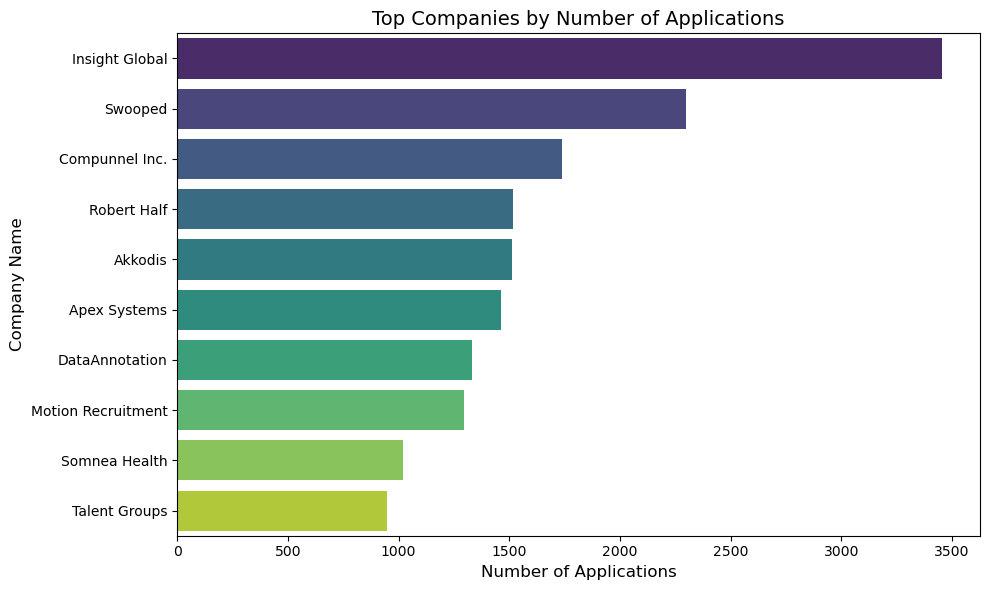

In [80]:
top_companies = df.groupby('company_name')['applies'].sum().sort_values(ascending=False).head(10).reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=top_companies, x='applies', y='company_name', palette='viridis')
plt.title('Top Companies by Number of Applications', fontsize=14)
plt.xlabel('Number of Applications', fontsize=12)
plt.ylabel('Company Name', fontsize=12)
plt.tight_layout()
plt.show()

# Extract relevant columns and clean data
df1 = df[['location', 'applies']].dropna()
df1['applies'] = pd.to_numeric(df1['applies'], errors='coerce')

# Calculate 25th and 75th percentiles for filtering
lower_bound = df1['applies'].quantile(0.25)
upper_bound = df1['applies'].quantile(0.75)

# Filter data between 25th and 75th percentiles based on applications
filtered_data = df1[(df1['applies'] >= lower_bound) & (df1['applies'] <= upper_bound)]

# Plot the violin plot
plt.figure(figsize=(12, 8))
sns.violinplot(x='location', y='applies', data=filtered_data, palette='viridis')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=90)

# Add labels and title
plt.xlabel("Location")
plt.ylabel("Applications")
plt.title("Violin Plot of Applications by Location (25th to 75th Percentile)")

# Show the plot
plt.show()

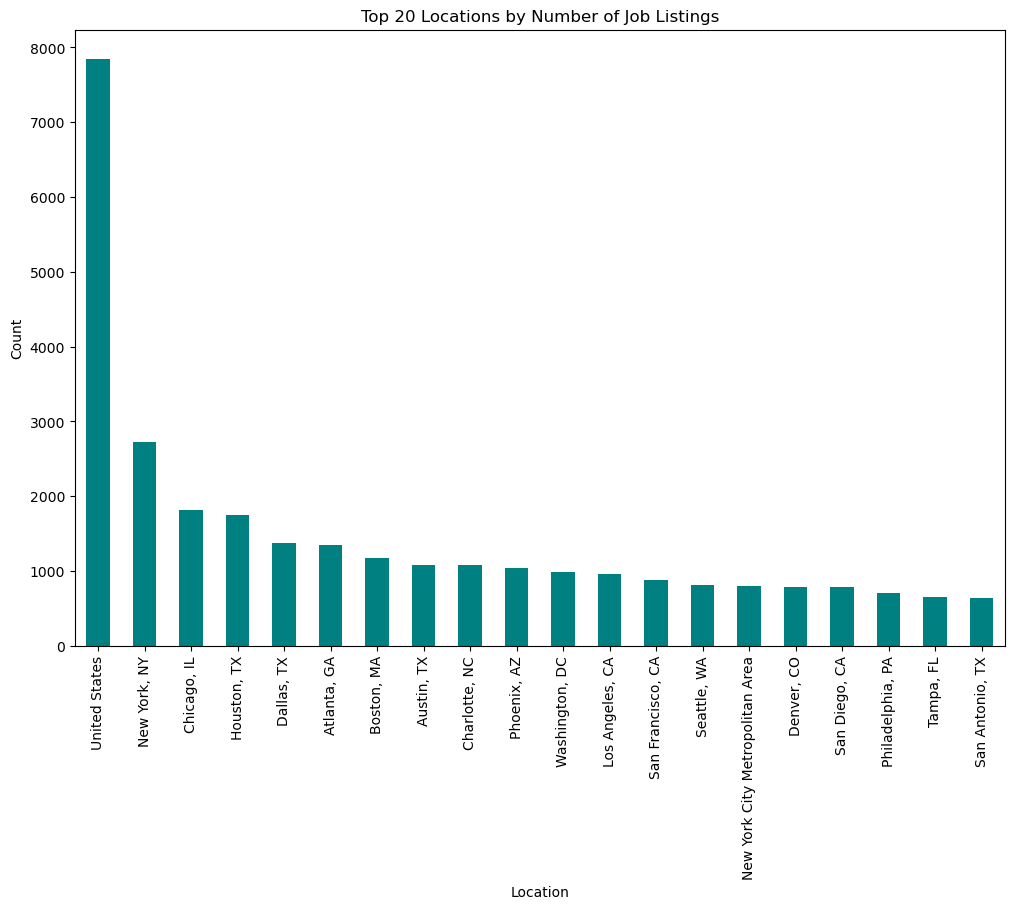

In [88]:
# 3. Number of job listings by location
plt.figure(figsize=(12, 8))
df['location'].value_counts().head(20).plot(kind='bar', color='teal')
plt.title('Top 20 Locations by Number of Job Listings')
plt.xlabel('Location')
plt.ylabel('Count')
plt.show()

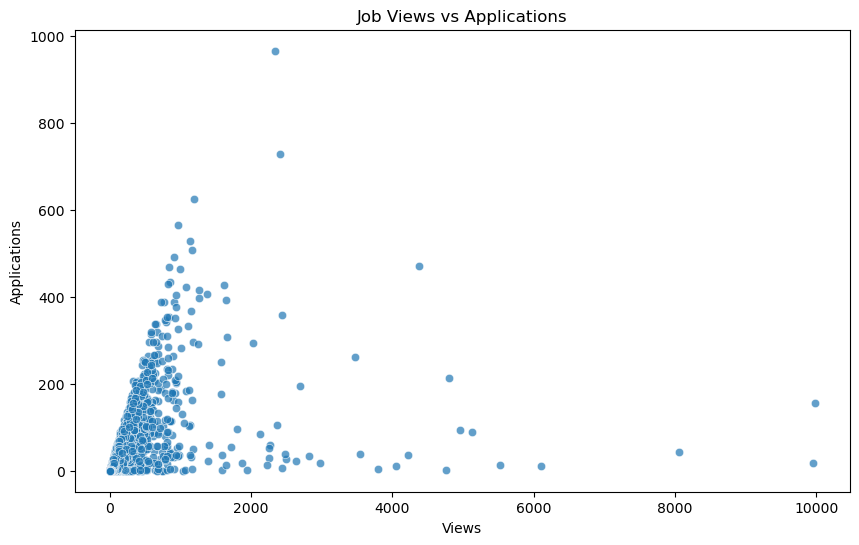

In [90]:
# 4. Number of job views vs. applications
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='views', y='applies', alpha=0.7)
plt.title('Job Views vs Applications')
plt.xlabel('Views')
plt.ylabel('Applications')
plt.show()


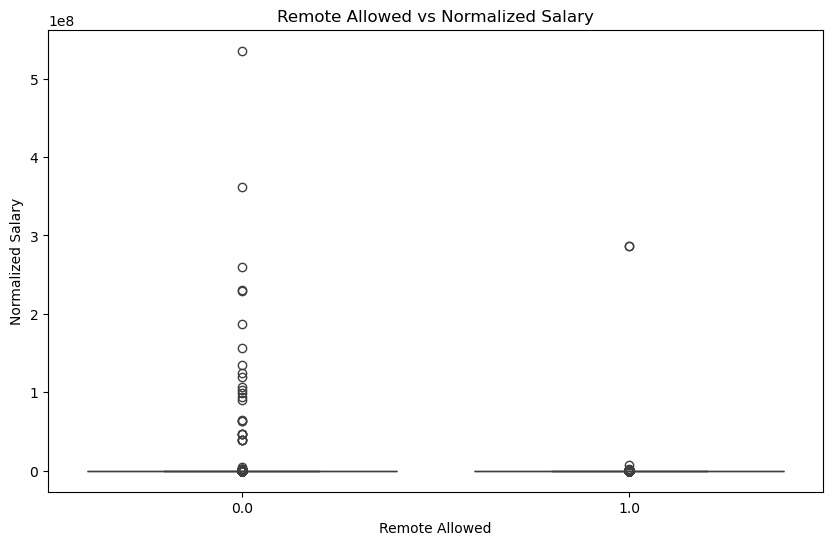

In [93]:
# 6. Remote allowance vs salary
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='remote_allowed', y='normalized_salary')
plt.title('Remote Allowed vs Normalized Salary')
plt.xlabel('Remote Allowed')
plt.ylabel('Normalized Salary')
plt.show()

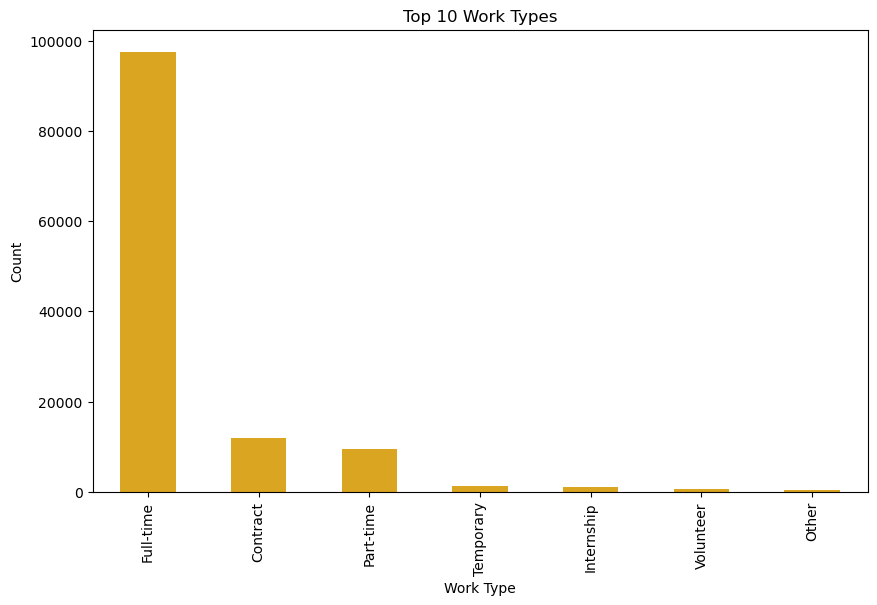

In [95]:
# 9. Popular work types
plt.figure(figsize=(10, 6))
df['formatted_work_type'].value_counts().head(10).plot(kind='bar', color='goldenrod')
plt.title('Top 10 Work Types')
plt.xlabel('Work Type')
plt.ylabel('Count')
plt.show()

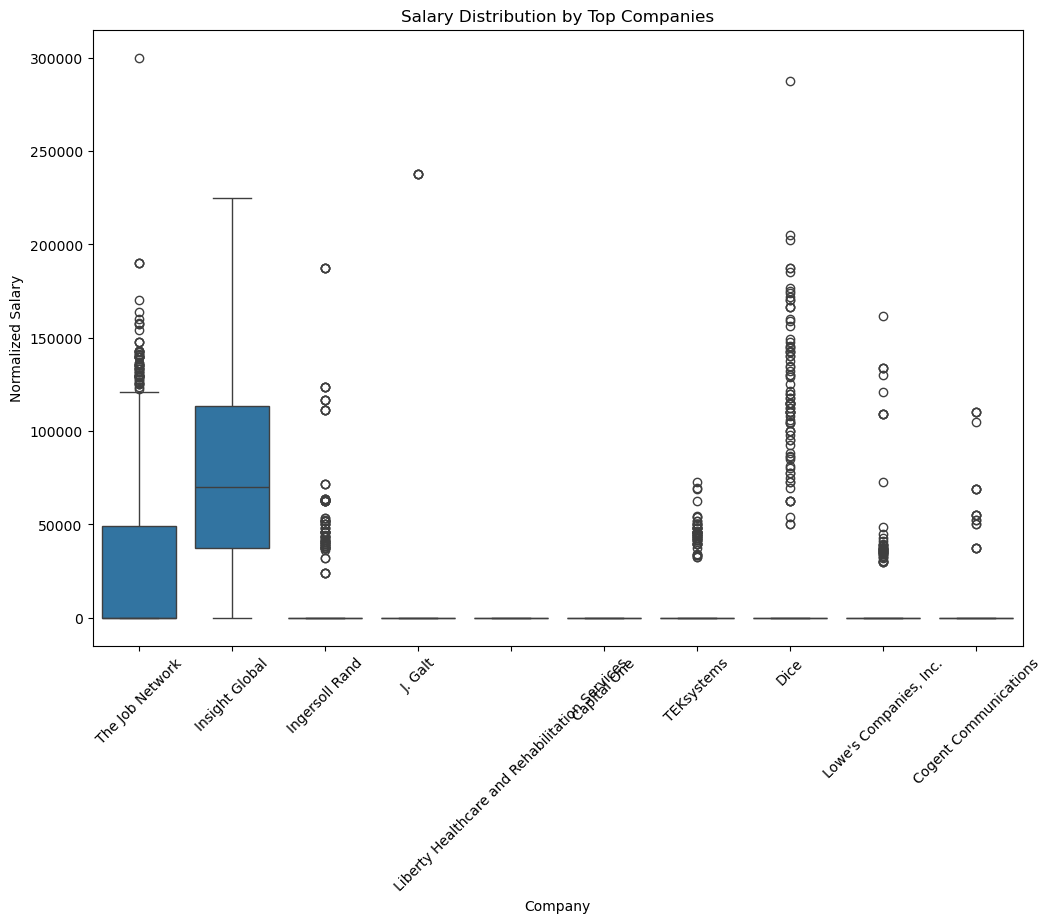

In [98]:
top_companies = df['company_name'].value_counts().head(10).index
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[df['company_name'].isin(top_companies)], x='company_name', y='normalized_salary')
plt.title('Salary Distribution by Top Companies')
plt.xlabel('Company')
plt.ylabel('Normalized Salary')
plt.xticks(rotation=45)
plt.show()

# Key Observations:
# Most Frequent Skills:

"People Skills" is the most frequently mentioned skill in job postings, appearing around 70 times. This indicates that interpersonal skills are highly valued across various job roles.
Other frequently listed skills include "Healthcare", "Hospice Care", and "Patient Care", suggesting a significant representation of roles in the healthcare or caregiving sectors.
# Communication Skills:

"Verbal/Written Communication" is among the top skills, highlighting its importance across many job domains.
# Specialized Skills:

Skills like "Fundraising", "CSR/Volunteer Coordination", and "Disaster Response" reflect a focus on nonprofit, social service, or community-based job roles.
# Diversity and Inclusion Keywords:

Skills such as "national origin", "color", "sexual orientation", and "age" appear in the list. These likely come from diversity and inclusion statements or requirements in job postings.
# Other Noteworthy Skills:

"Public Relations", "Networking", and "Organization" are also prominent, which are essential for managerial and collaborative roles.
"Relationship Building" suggests the importance of maintaining partnerships or client relationships in professional settings.
# Context-Specific Insights:

# Industry Focus:

The prominence of healthcare-related skills (e.g., "Healthcare," "Hospice Care") suggests a strong focus on roles in the medical or caregiving industries in this dataset.
Social impact skills such as "Community Outreach" and "Volunteer Coordination" indicate that nonprofit and volunteer-driven roles are also well-represented.
# Demand for Soft Skills:

The prevalence of skills like "People Skills" and "Verbal/Written Communication" suggests that employers highly value interpersonal and communication skills in addition to technical expertise.
# Possible Data Noise:

Some entries, such as "This position requires the following skills", appear to result from improper parsing or incomplete text cleaning of the dataset. These could slightly skew the analysis.

# Conclusion:
This visualization highlights that both soft skills (e.g., "People Skills," "Communication") and domain-specific skills (e.g., "Healthcare," "Fundraising") are essential in job postings. The dataset's focus on healthcare and nonprofit sectors is evident, but further analysis and data refinement could provide a more nuanced understanding of skill demands.

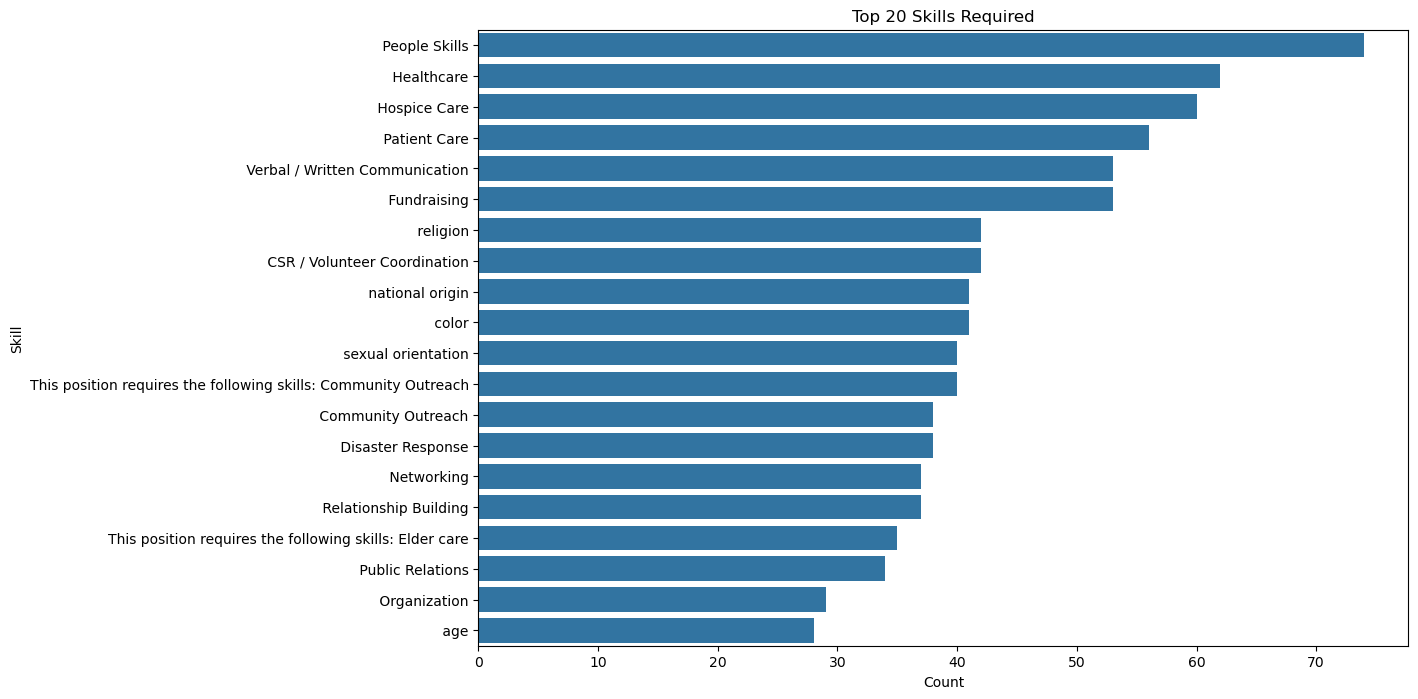

In [100]:
# 12. Top skills required
from collections import Counter
skills = df['skills_desc'].dropna().str.split(',').explode()
skill_counts = Counter(skills)
skill_df = pd.DataFrame(skill_counts.items(), columns=['Skill', 'Count']).sort_values(by='Count', ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(data=skill_df.head(20), x='Count', y='Skill')
plt.title('Top 20 Skills Required')
plt.xlabel('Count')
plt.ylabel('Skill')
plt.show()

The box plot shown in the graph compares the number of job views (views) for jobs that allow remote work (remote_allowed=1) versus those that do not (remote_allowed=0). Here’s a detailed analysis of the insights derived from this visualization:

### Key Observations:
1. *Median Views for Remote and Non-Remote Jobs*:
   - The median number of views for both categories is relatively low, indicating that most jobs receive limited views.
   
2. *Outliers*:
   - There are significant outliers in both categories, with some jobs receiving an exceptionally high number of views (e.g., close to 10,000).
   - These outliers suggest that certain job postings attract far more attention than others, which might depend on factors such as job title, location, or description quality.

3. *Distribution*:
   - The data for both categories is highly skewed, with most jobs receiving few views and only a few receiving many.
   - This skewness is reflected by the dense clustering near the bottom of the plot.

4. *Comparison Between Remote and Non-Remote Jobs*:
   - From the box plot, it’s unclear if there’s a consistent preference for remote or non-remote jobs in terms of views. Both categories have similar spreads and outliers, indicating that remote work alone might not be the dominant factor affecting job view counts.

### Additional Insights to Explore:
- *Investigating Factors Driving Outliers*:
  - Analyze whether the jobs with the highest views belong to specific industries, locations, or job titles.
  - Determine if these outliers are influenced by other features like salary or company reputation.

- *Evaluating Statistical Differences*:
  - Perform a statistical test (e.g., t-test or Mann-Whitney U test) to determine if the differences in median views between the two categories are significant.

- *Feature Importance*:
  - Consider including other features like job level, industry, or salary in a regression analysis to see if remote work impacts views when controlling for other factors.

- *Correlations*:
  - Check for correlations between remote_allowed and other numeric variables (like salary, if available) to understand the relationships better.

### Conclusion:
This graph provides a preliminary comparison of job views for remote versus non-remote positions. While there are no strong visual indications of one being more popular, further analysis incorporating additional variables or statistical tests is recommended to draw more concrete conclusions.

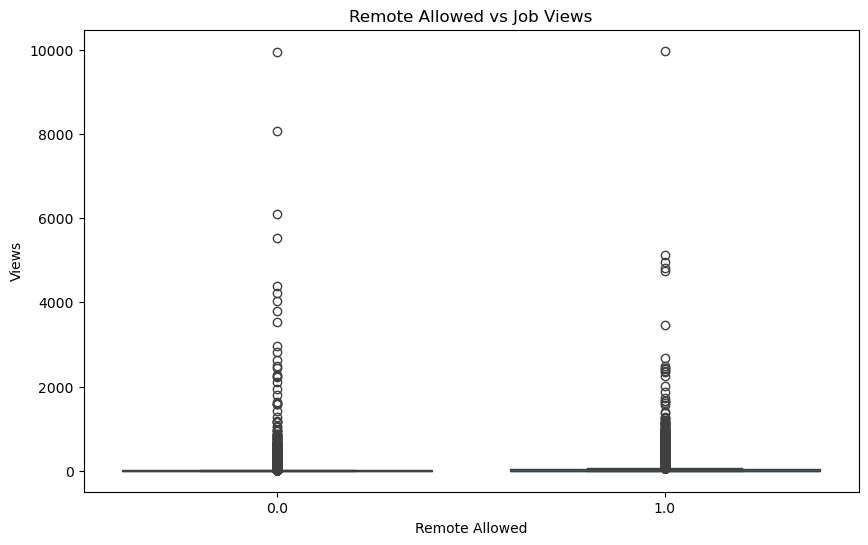

In [101]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='remote_allowed', y='views')
plt.title('Remote Allowed vs Job Views')
plt.xlabel('Remote Allowed')
plt.ylabel('Views')
plt.show()

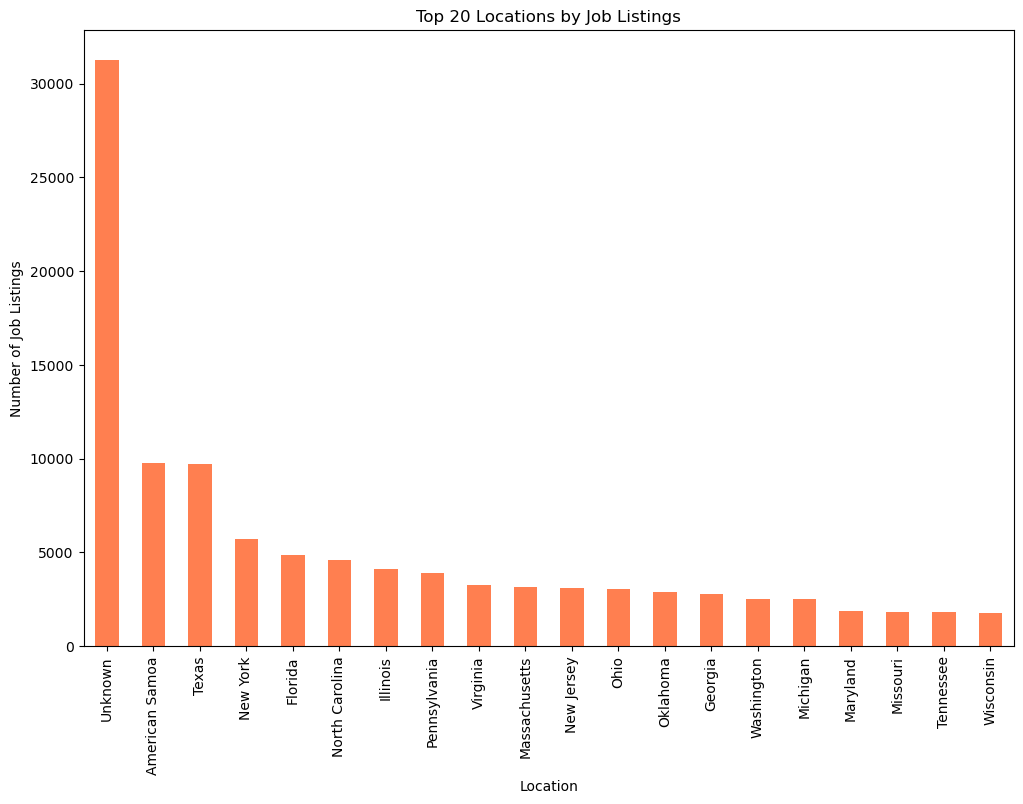

In [105]:
import us  # Library for US state information

# Function to map FIPS code to state name
def fips_to_location(fips_code):
    if pd.isna(fips_code):
        return "Unknown"
    try:
        state = us.states.lookup(fips_code[:2])  # First two digits for state code
        return state.name if state else "Unknown"
    except Exception as e:
        return "Unknown"

# Apply the mapping
df['location_name'] = df['fips'].astype(str).apply(fips_to_location)

# Plot the top 20 locations by FIPS code
top_locations = df['location_name'].value_counts().head(20)

plt.figure(figsize=(12, 8))
top_locations.plot(kind='bar', color='coral')
plt.title('Top 20 Locations by Job Listings')
plt.xlabel('Location')
plt.ylabel('Number of Job Listings')
plt.show()